In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist


In [25]:
clear_df = pd.read_pickle("../utils/data/clear_functional.pkl")
# clear_df = pd.read_pickle("../utils/data/clear_functional_emovo.pkl")

# clear_df = pd.read_pickle("pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("pitch_functional_emovo.pkl")

In [26]:
def get_speaker(clear_df, speaker):
    names = clear_df.filename.to_list()

    test = []
    m = 0
    names
    for i in range(len(clear_df)):
        if speaker in names[i]:
            test.append(names[i])
            m +=1

    mask = clear_df['filename'].isin(test)
    test_df = clear_df[mask].reset_index()
    train_df = clear_df[~mask].reset_index()
    return  train_df, test_df

# train_df = clear_df.drop(test_df.index).reset_index()

In [27]:
labels = clear_df["label"].unique()
labels

array(['neutral', 'guilt', 'disgust', 'happiness', 'fear', 'anger',
       'surprise', 'sadness'], dtype=object)

In [28]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask]
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df


In [29]:
train_df, test_df = get_speaker(clear_df, "f_01")

In [30]:
train_df, val_df = get_speaker(train_df, "f_36")

In [31]:
val_df

,level_0,index,filename,features,label
0,18,24,f_36_neu00a.wav,F0semitoneFr...,neutral
1,19,25,f_36_neu01b.wav,F0semitoneFr...,neutral
2,20,26,f_36_neu02b.wav,F0semitoneFr...,neutral
3,21,27,f_36_neu03b.wav,F0semitoneFr...,neutral
4,22,28,f_36_neu04b.wav,F0semitoneFr...,neutral
...,...,...,...,...,...
196,8264,8389,PR_f_36_gio94b.wav,F0semitoneFr...,happiness
197,8265,8390,PR_f_36_pau01c.wav,F0semitoneFr...,fear
198,8266,8391,PR_f_36_pau12b.wav,F0semitoneFr...,fear
199,8267,8392,PR_f_36_tri01c.wav,F0semitoneFr...,sadness


In [32]:
train = []

for i,emotion in enumerate(labels):
    train.append(get_emo_df(emotion,train_df))

Processing neutral ...
Processed 320 file for neutral
Processing guilt ...
Processed 1092 file for guilt
Processing disgust ...
Processed 1625 file for disgust
Processing happiness ...
Processed 1348 file for happiness
Processing fear ...
Processed 1112 file for fear
Processing anger ...
Processed 1427 file for anger
Processing surprise ...
Processed 968 file for surprise
Processing sadness ...
Processed 1478 file for sadness


In [33]:
test = []

for i,emotion in enumerate(labels):
    test.append(get_emo_df(emotion,test_df))

Processing neutral ...
Processed 6 file for neutral
Processing guilt ...
Processed 14 file for guilt
Processing disgust ...
Processed 21 file for disgust
Processing happiness ...
Processed 16 file for happiness
Processing fear ...
Processed 15 file for fear
Processing anger ...
Processed 21 file for anger
Processing surprise ...
Processed 13 file for surprise
Processing sadness ...
Processed 19 file for sadness


In [34]:
val = []

for i,emotion in enumerate(labels):
    val.append(get_emo_df(emotion,val_df))

Processing neutral ...
Processed 6 file for neutral
Processing guilt ...
Processed 23 file for guilt
Processing disgust ...
Processed 32 file for disgust
Processing happiness ...
Processed 31 file for happiness
Processing fear ...
Processed 29 file for fear
Processing anger ...
Processed 29 file for anger
Processing surprise ...
Processed 19 file for surprise
Processing sadness ...
Processed 32 file for sadness


In [35]:
def split_train_val(data):
    data_classes = (list((data["label"].unique())))
    Y = keras.utils.to_categorical(list((data["label"].apply(data_classes.index))))
    X = pd.concat(data["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    X_train, X_val, y_train, y_val = train_test_split(_X, Y, test_size=0.2, random_state=22)
    _X_train = X_train.to_numpy()
    _X_val = X_val.to_numpy()
    
    return _X_train, _X_val, y_train, y_val


def obtain_test(data):
    data_classes = (list((data["label"].unique())))
    Y = keras.utils.to_categorical(list((data["label"].apply(data_classes.index))))
    X = pd.concat(data["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())

    _X_test = _X.to_numpy()
    return _X_test

In [36]:
def build_autoencoder(neurons_in=16, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck'))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation=act_function, name='decoded'))
    # ac = Model(input_l,output_l)
    

    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return model

In [37]:
from datetime import datetime  
def train_autoencoder(emotion,data_train, data_val):
    name = datetime.now().strftime(f"model/autoencoders_one_out/boxplot/ae_{emotion}_demos_%d_%m_%Y_%H_%M_%S.keras")
    print(f"training on {emotion}")
    print(f"Model name : {name}")
    ae = build_autoencoder(28,"sigmoid","adam",0)
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=0,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    ]

    # _X_train, _X_val, y_train, y_val = split_train_val(data_train)


    _X_train =  obtain_test(data_train)
    _X_val =  obtain_test(data_val)
    history = ae.fit(_X_train,_X_train,
                validation_data = (_X_val,_X_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                callbacks = callbacks)
    
    print("last loss: ", history.history['val_loss'][-1])
    return ae

In [38]:
val[0]

,level_0,filename,features,label
0,18,f_36_neu00a.wav,F0semitoneFr...,neutral
1,19,f_36_neu01b.wav,F0semitoneFr...,neutral
2,20,f_36_neu02b.wav,F0semitoneFr...,neutral
3,21,f_36_neu03b.wav,F0semitoneFr...,neutral
4,22,f_36_neu04b.wav,F0semitoneFr...,neutral
5,23,f_36_neu05b.wav,F0semitoneFr...,neutral


In [39]:
autoencoders = []
# val = [0] * 10000
for i,emotion in enumerate(labels):
    autoencoders.append(train_autoencoder(emotion, train[i], val[i]))

training on neutral
Model name : model/autoencoders_one_out/boxplot/ae_neutral_demos_22_11_2024_16_00_41.keras
last loss:  0.7656843662261963
training on guilt
Model name : model/autoencoders_one_out/boxplot/ae_guilt_demos_22_11_2024_16_00_45.keras
last loss:  0.6972986459732056
training on disgust
Model name : model/autoencoders_one_out/boxplot/ae_disgust_demos_22_11_2024_16_00_51.keras
last loss:  0.6027344465255737
training on happiness
Model name : model/autoencoders_one_out/boxplot/ae_happiness_demos_22_11_2024_16_02_02.keras
last loss:  0.6012852787971497
training on fear
Model name : model/autoencoders_one_out/boxplot/ae_fear_demos_22_11_2024_16_02_49.keras
last loss:  0.6090075969696045
training on anger
Model name : model/autoencoders_one_out/boxplot/ae_anger_demos_22_11_2024_16_03_59.keras
last loss:  0.7158052921295166
training on surprise
Model name : model/autoencoders_one_out/boxplot/ae_surprise_demos_22_11_2024_16_04_05.keras
last loss:  0.5836820006370544
training on sa

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []
y_pred = []
errors = []

for n in tqdm(range(len(test))):
    X_test = obtain_test(test[n])
    # print("test ottenuto")
    cls = []
    for i in tqdm(range(len(X_test))):
        _er = []
        for encoder in autoencoders :
            #print(labels[x])
            _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose = 0).reshape(88,)))
        errors.append(_er)
        y_pred.append(np.argmin(_er))
        y_true.append(n)
    #pred.append(cls)

100%|██████████| 8/8 [01:26<00:00, 10.84s/it]


0.16
0.08848742228598758


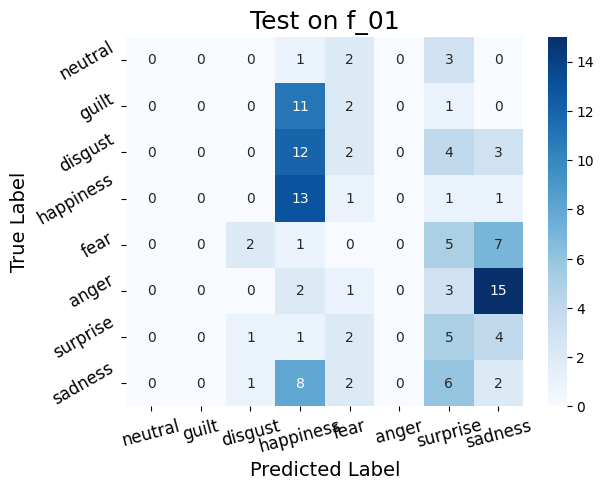

In [41]:
cm = confusion_matrix(y_true,y_pred)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("Test on f_01", fontsize = 18)

print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average ="weighted"))

# plt.savefig("One_speaker_out_female.png")

In [25]:
test_errors = errors

In [26]:
train_errors = errors

In [38]:
import pickle
with open('errors_train_demos.pkl', 'wb') as handle:
    pickle.dump(train_errors, handle)



# with open('errors_test_demos.pkl', 'wb') as handle:
#     pickle.dump(test_errors, handle)

In [1]:
import pickle
with open('errors_train_demos.pkl', 'rb') as handle:
    prova_train = pickle.load(handle)



# with open('errors_test_demos.pkl', 'rb') as handle:
#     prova_test = pickle.load(handle)



prova_train == train_errors, prova_test == test_errors

NameError: name 'train_errors' is not defined

In [27]:
import pickle
with open('errors_train_demos.pkl', 'rb') as handle:
    train_errors = pickle.load(handle)



with open('errors_test_demos.pkl', 'rb') as handle:
    test_errors = pickle.load(handle)


data_train =np.array(train_errors)
data_test = np.array(test_errors)


In [32]:
data_train = np.array(train_errors)

In [33]:
emo = []

for i in range(0,data_train.shape[0],70):
    emo.append(data_train[i:i+70])


In [29]:
emo_test = []

for i in range(0,data_test.shape[0],14):
    emo_test.append(data_test[i:i+14])


In [30]:
emo[0][:,0]

array([0.00884276, 0.00822179, 0.00295549, 0.01439629, 0.00664375,
       0.00629719, 0.00985587, 0.00426281, 0.00302997, 0.00687592,
       0.00440858, 0.00469992, 0.00773343, 0.00325961, 0.00401602,
       0.01150695, 0.00725989, 0.00761355, 0.00712722, 0.00820202,
       0.00452104, 0.00560086, 0.0043171 , 0.00819095, 0.00469834,
       0.00693257, 0.00575657, 0.00464633, 0.0069342 , 0.00644785,
       0.0053757 , 0.0038364 , 0.00254492, 0.00413592, 0.00705271,
       0.00859336, 0.01044658, 0.0056851 , 0.00222507, 0.00542017,
       0.00846541, 0.01306677, 0.00325394, 0.00309206, 0.00548965,
       0.00408218, 0.00933453, 0.00703206, 0.00437413, 0.00340292,
       0.00597174, 0.00788191, 0.00975752, 0.00967901, 0.00628392,
       0.00611098, 0.00865279, 0.0165773 , 0.00571653, 0.00656632,
       0.00690023, 0.00523463, 0.00821099, 0.0052163 , 0.00434133,
       0.01640012, 0.00561086, 0.00298062, 0.0046134 , 0.01053026],
      dtype=float32)

In [33]:
from scipy import stats

stats.ttest_ind(emo[0][:,0], emo[0][:,1])
# stats.ttest_ind(emo[0][:,0], emo[0][:,2])
# stats.ttest_ind(emo[0][:,0], emo[0][:,3])
# stats.ttest_ind(emo[0][:,0], emo[0][:,4])
# stats.ttest_ind(emo[0][:,0], emo[0][:,5])
# stats.ttest_ind(emo[0][:,0], emo[0][:,6])


TtestResult(statistic=-42.99539604466775, pvalue=8.483827893352115e-82, df=138.0)

In [31]:
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,1])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,2])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,3])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,4])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,5])
stats.ttest_ind(emo_test[0][:,0], emo_test[0][:,6])

NameError: name 'stats' is not defined

array([0.07545061, 0.06855144, 0.06272581, 0.07084192, 0.0693512 ,
       0.0540144 , 0.07123087, 0.05788324, 0.06352156, 0.07319525,
       0.0621804 , 0.06318045, 0.06051015, 0.07349839, 0.06148316,
       0.08067355, 0.07340674, 0.07127085, 0.06183388, 0.06490787,
       0.08704992, 0.07483453, 0.06919084, 0.06473618, 0.08623195,
       0.0678684 , 0.05836773, 0.06644074, 0.05801413, 0.07974844,
       0.06413043, 0.07865271, 0.06334627, 0.05763096, 0.04399718,
       0.06224738, 0.05372484, 0.05441376, 0.06188612, 0.06381809,
       0.06243311, 0.06791601, 0.05214637, 0.05273981, 0.05310698,
       0.06726725, 0.04911327, 0.0681304 , 0.06636572, 0.06515829,
       0.06090077, 0.0610003 , 0.04993146, 0.0598748 , 0.06069404,
       0.06503039, 0.05517886, 0.08267196, 0.07029719, 0.07315434,
       0.05708062, 0.06340118, 0.05538113, 0.05724164, 0.07453174,
       0.06529299, 0.06094887, 0.08446244, 0.06977248, 0.08273352],
      dtype=float32)

IndexError: index 7 is out of bounds for axis 0 with size 7

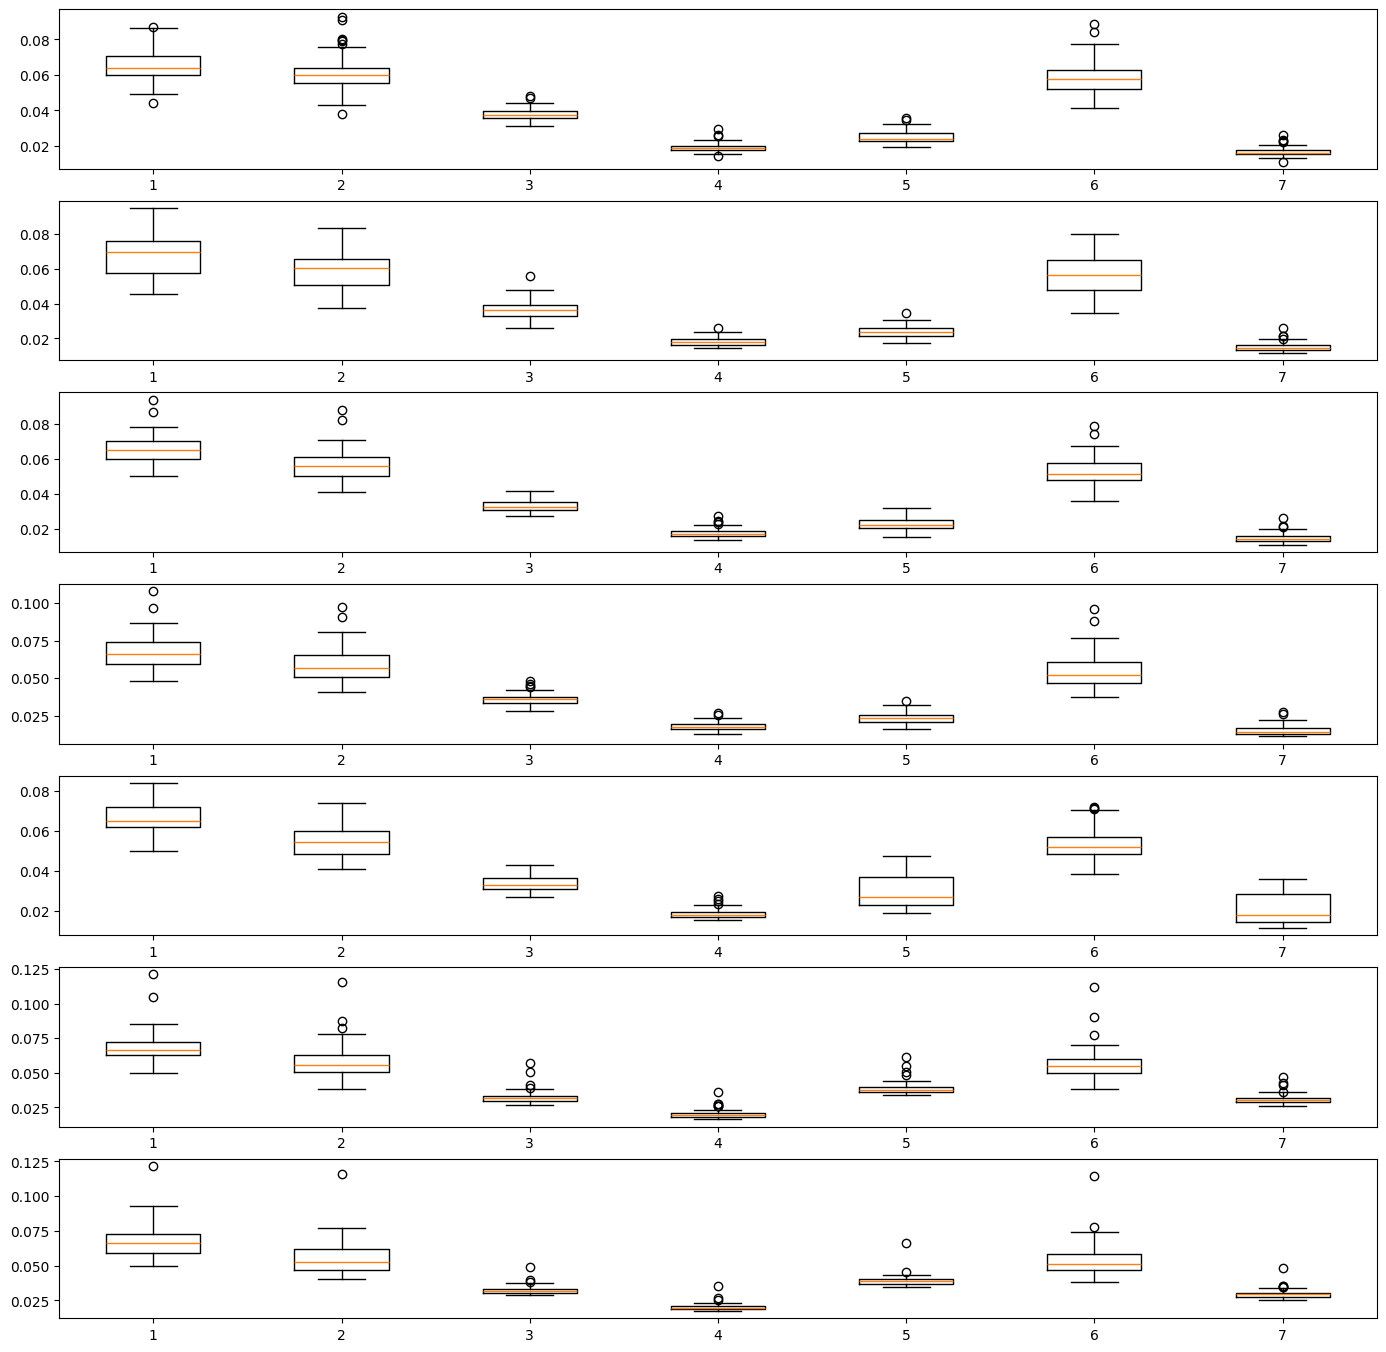

In [37]:
# data_train =np.array(errro_train)
# data_test =np.array(test_errors)
n_rows = 7
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(17,17))
# for x in range(n_rows):
for i in range(len(emo)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)

    axes[i].boxplot([emo[i][:,0], emo[i][:,1],emo[i][:,2],emo[i][:,3],emo[i][:,4],emo[i][:,5],emo[i][:,6]])
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Train")

# plt.savefig("OvA_EMOVO_train.png")

In [96]:
data_test.shape

(98, 7)

In [98]:
for i in range(len(emo_test)):
    print(emo_test[i].shape)

(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)
(14, 7)


In [105]:
labels

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

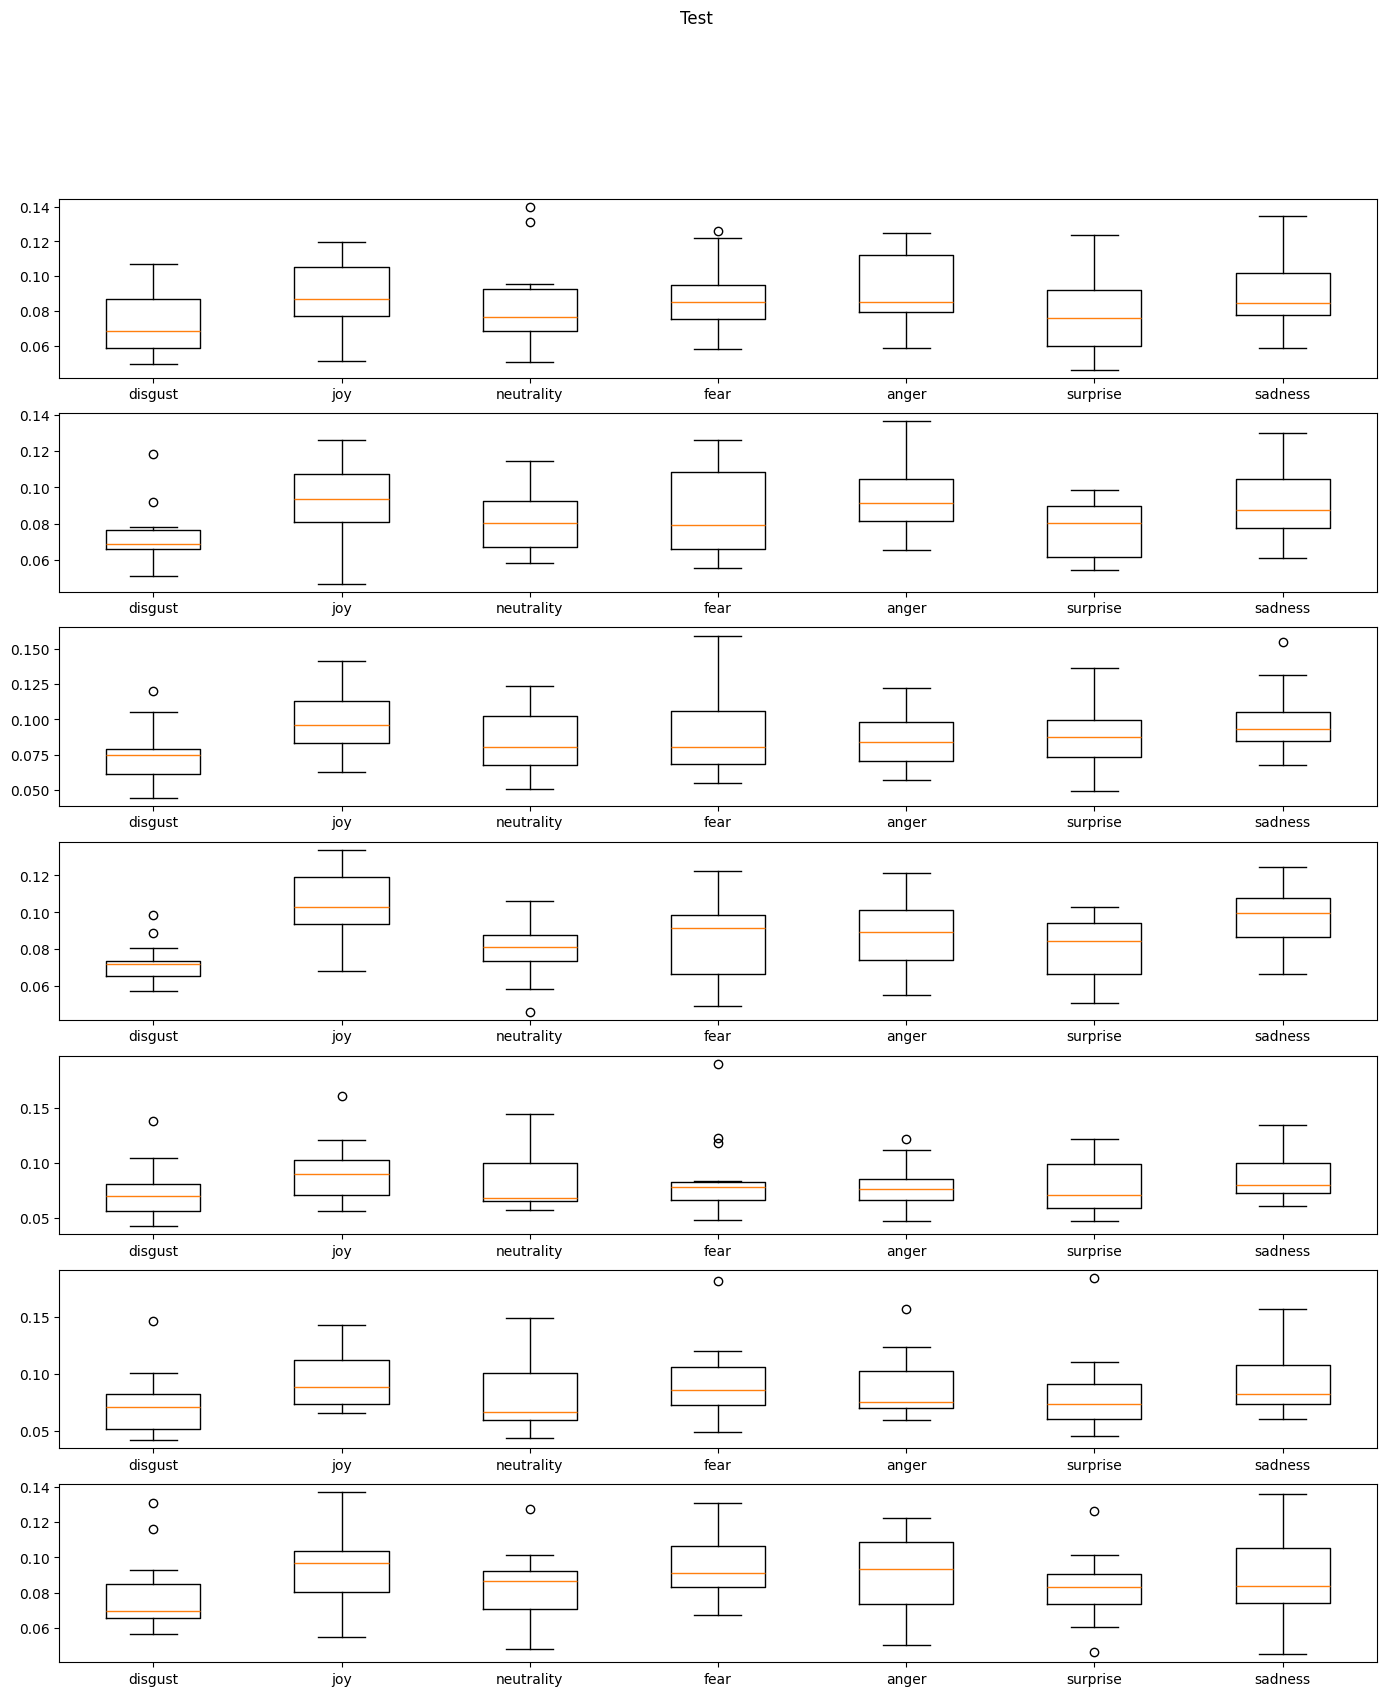

In [104]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 7
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(17,19))
# for x in range(n_rows):
for i in range(len(emo_test)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)

    axes[i].boxplot([emo_test[i][:,0], emo_test[i][:,1],emo_test[i][:,2],emo_test[i][:,3],emo_test[i][:,4],emo_test[i][:,5],emo_test[i][:,6]], tick_labels=labels )
    # axes[i].set_title(f"{labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

In [ ]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        totale = np.concatenate((data_test[14:, :i], data_test[14:, i:]), axis=1)

        axes[x,i].boxplot([data_test[14:,i], np.mean(totale, axis=1)], tick_labels=[f"{labels[i]}", "Others"])
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

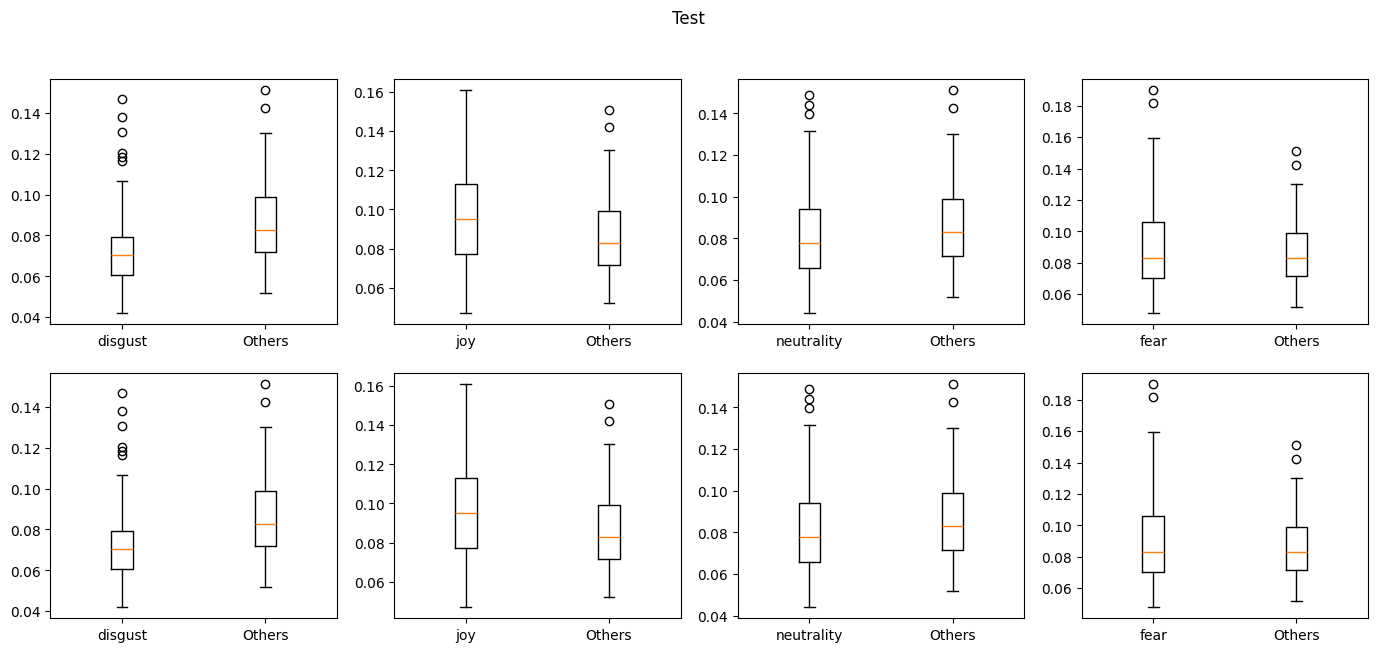

In [47]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        totale = np.concatenate((data_test[:, :i], data_test[:, i:]), axis=1)

        axes[x,i].boxplot([data_test[:,i], np.mean(totale, axis=1)], tick_labels=[f"{labels[i]}", "Others"])
        # axes[x,i].set_title(f"{labels[i]}")
fig.suptitle("Test")

plt.savefig("OvA_EMOVO_test.png")

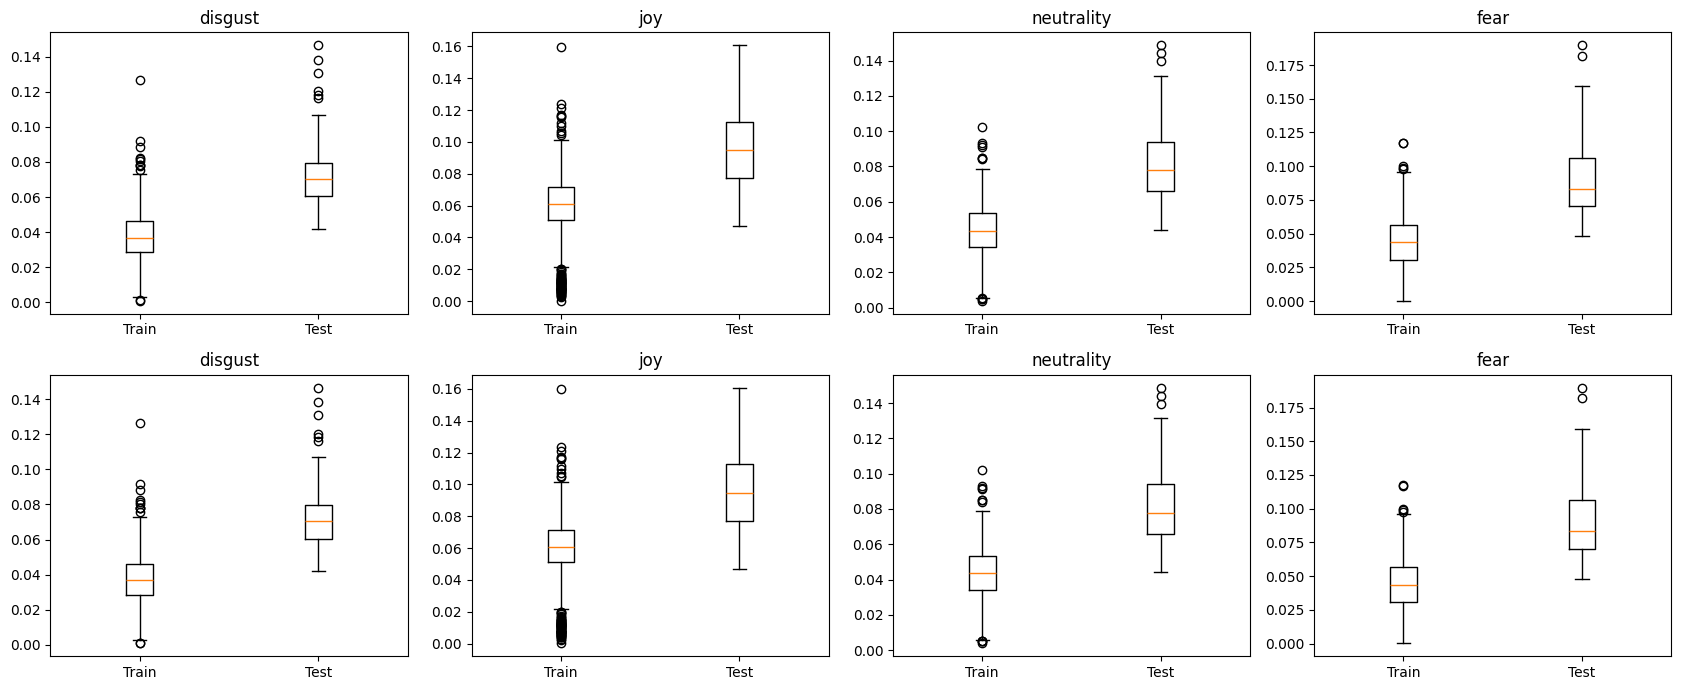

In [27]:
# fig, ax = plt.subplots()
data_train =np.array(errro_train)
data_test =np.array(test_errors)
n_rows = 2
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17,7))
for x in range(n_rows):
    for i in range(4):
    # Crea i boxplot
        axes[x,i].boxplot([data_train[:,i], data_test[:,i]], tick_labels=['Train', 'Test'])
        axes[x,i].set_title(f"{labels[i]}")



plt.tight_layout()
plt.savefig("Confronto_EMOVO.png")
# Personalizza il grafico (opzionale)
# plt.title('Confronto tra due set di dati')
# plt.ylabel('Reconstruction errro')

{'whiskers': [<matplotlib.lines.Line2D at 0x1ee246b2720>,
 'caps': [<matplotlib.lines.Line2D at 0x1ee246b11f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ee246b3200>],
 'medians': [<matplotlib.lines.Line2D at 0x1ee276c5dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ee276c66f0>],
 'means': []}

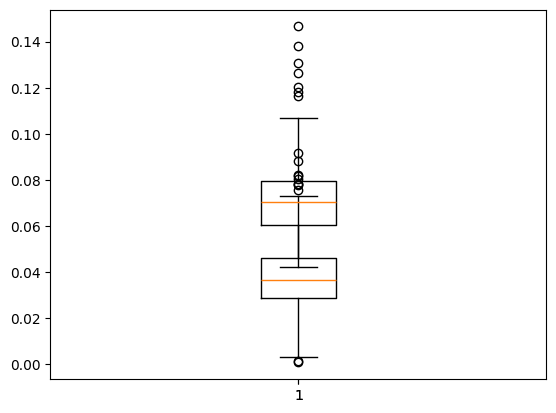

In [12]:
data_train =np.array(errro_train)
data_test =np.array(test_errors)

plt.boxplot(data_train[:,0])
plt.boxplot(data_test[:,0])


# for i in range(7):
#     ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

Text(0, 0.5, 'Reconstruction error')

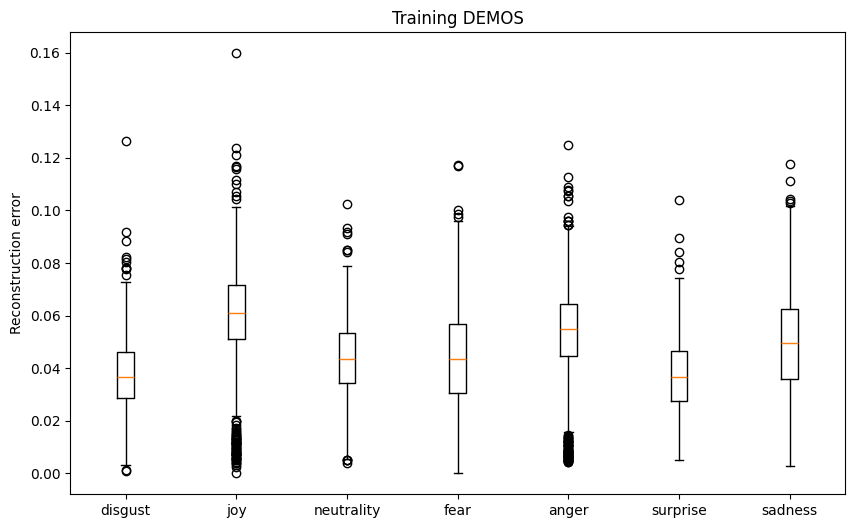

In [7]:
data =np.array(errro_train)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Training DEMOS")
ax.set_ylabel("Reconstruction error")


# plt.show()
# plt.savefig("Boxplot_DEMOS_train.png")

Text(0, 0.5, 'Reconstruction error')

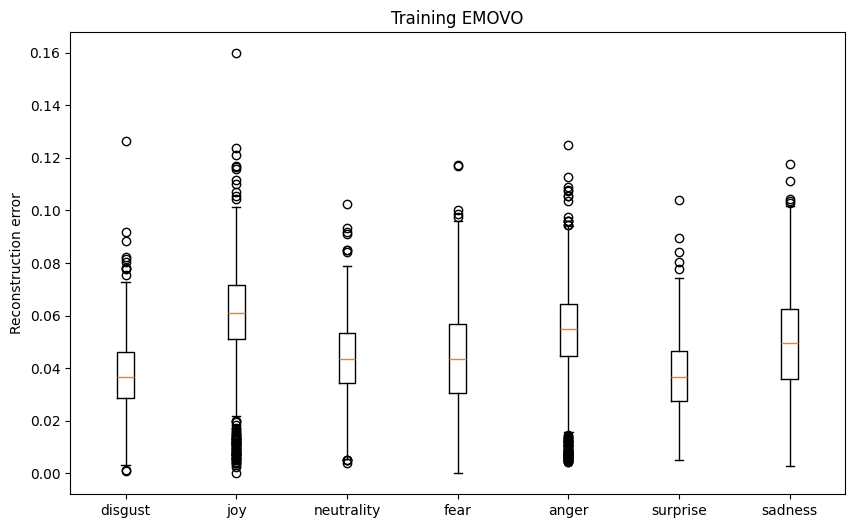

In [8]:
data =np.array(errro_train)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Training EMOVO")
ax.set_ylabel("Reconstruction error")


# plt.show()
# plt.savefig("Boxplot_EMOVO_train.png")

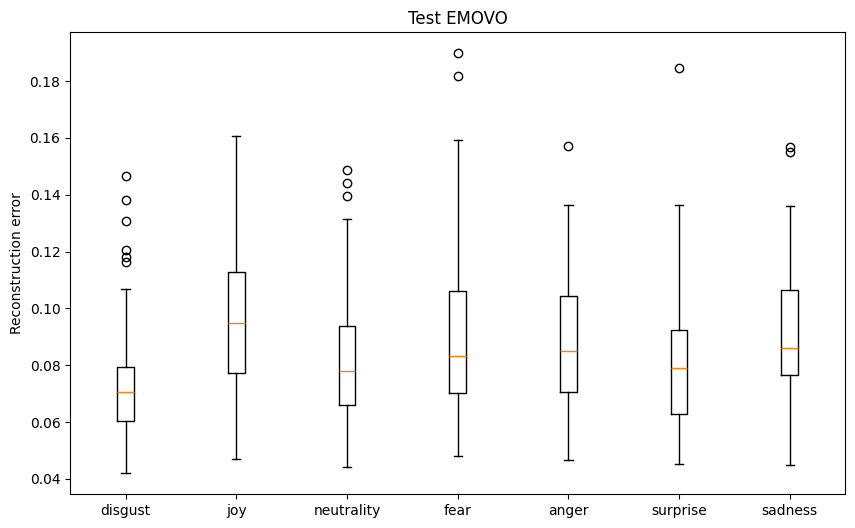

In [81]:
data =np.array(test_errors)
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(7):
    ax.boxplot(data[:, i], positions=[i+1], tick_labels=[f"Dimension {i+1}"])

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 8))
ax.set_xticklabels([f"{labels[i]}" for i in range(7)])

# Set the title and labels
ax.set_title("Test EMOVO")
ax.set_ylabel("Reconstruction error")

# plt.show()
plt.savefig("Boxplot_EMOVO_test.png")

In [ ]:
import pickle
with open('errors_train_demos.pkl', 'wb') as handle:
    pickle.dump(errro_train, handle)



with open('errors_test_demos.pkl', 'wb') as handle:
    pickle.dump(errors, handle)

{'whiskers': [<matplotlib.lines.Line2D at 0x2400bdeff50>,
 'caps': [<matplotlib.lines.Line2D at 0x2400bd94560>,
 'boxes': [<matplotlib.lines.Line2D at 0x2400bdefcb0>],
 'medians': [<matplotlib.lines.Line2D at 0x2400bd94ad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2400bd94d70>],
 'means': []}

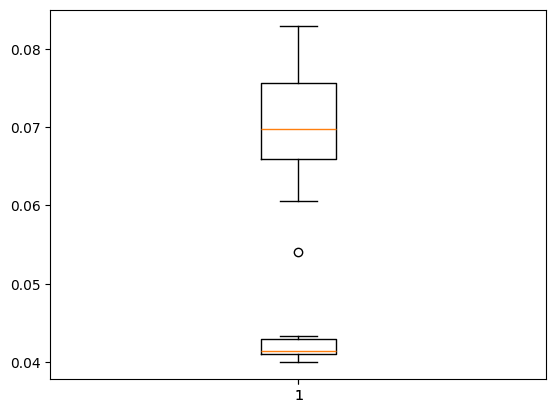

In [27]:
plt.boxplot(np.mean(errors, axis=0))
plt.boxplot(np.mean(errro_train, axis=0))

In [ ]:
predict su training - boxplot (2 boxplot uno train uno test - )

In [18]:
errors[:12]

[[0.09776781,
  0.14706425,
  0.11928873,
  0.09415389,
  0.11661363,
  0.12297818,
  0.08031848,
  0.10203273],
 [0.05326116,
  0.062158205,
  0.07045445,
  0.060693968,
  0.08329714,
  0.08979998,
  0.067464896,
  0.06583438],
 [0.04792208,
  0.06559345,
  0.075408265,
  0.06660958,
  0.09114426,
  0.08414332,
  0.079307675,
  0.061760448],
 [0.07286747,
  0.07093237,
  0.09779748,
  0.08671812,
  0.09551246,
  0.10390114,
  0.080414146,
  0.09003662],
 [0.06483802,
  0.08864486,
  0.097491264,
  0.07106492,
  0.10944128,
  0.0963198,
  0.07908068,
  0.072883025],
 [0.104773924,
  0.13794874,
  0.13338241,
  0.10221284,
  0.13701142,
  0.13418517,
  0.121240266,
  0.10875473],
 [0.10173703,
  0.12664205,
  0.120765574,
  0.10304007,
  0.13230932,
  0.12629849,
  0.117886655,
  0.12741715],
 [0.065119125,
  0.085141,
  0.08670609,
  0.08568755,
  0.10883519,
  0.10603907,
  0.08245248,
  0.08543436],
 [0.05053078,
  0.07791419,
  0.069114596,
  0.07476472,
  0.084046535,
  0.08424477,

In [13]:
y_true[:12], y_pred[:12], errors[:12]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [6, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0],
 [[0.09776781,
   0.14706425,
   0.11928873,
   0.09415389,
   0.11661363,
   0.12297818,
   0.08031848,
   0.10203273],
  [0.05326116,
   0.062158205,
   0.07045445,
   0.060693968,
   0.08329714,
   0.08979998,
   0.067464896,
   0.06583438],
  [0.04792208,
   0.06559345,
   0.075408265,
   0.06660958,
   0.09114426,
   0.08414332,
   0.079307675,
   0.061760448],
  [0.07286747,
   0.07093237,
   0.09779748,
   0.08671812,
   0.09551246,
   0.10390114,
   0.080414146,
   0.09003662],
  [0.06483802,
   0.08864486,
   0.097491264,
   0.07106492,
   0.10944128,
   0.0963198,
   0.07908068,
   0.072883025],
  [0.104773924,
   0.13794874,
   0.13338241,
   0.10221284,
   0.13701142,
   0.13418517,
   0.121240266,
   0.10875473],
  [0.10173703,
   0.12664205,
   0.120765574,
   0.10304007,
   0.13230932,
   0.12629849,
   0.117886655,
   0.12741715],
  [0.065119125,
   0.085141,
   0.08670609,
   0.08568755,
   0

Text(0.5, 1.0, 'Test on f_01')

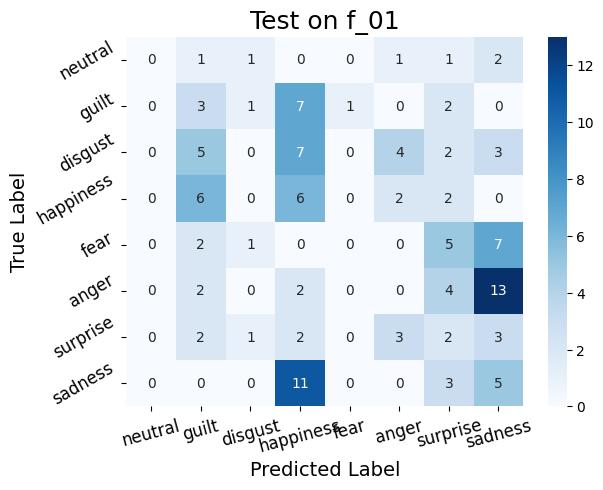

In [32]:
cm = confusion_matrix(y_true,y_pred)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("Test on f_01", fontsize = 18)

# plt.savefig("One_speaker_out_female.png")

In [15]:
# cm = confusion_matrix(y_true,y_pred)

# g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
# g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
# g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
# g.set_xlabel("Predicted Label", fontsize=14)
# g.set_ylabel("True Label", fontsize = 14)
# # g.set_title(data, fontsize = 18)

# plt.savefig("One_speaker_out_male.png")

In [33]:
from sklearn.metrics import average_precision_score
score = 1 - np.array(errors)
true_lab = y_true
ap = average_precision_score(true_lab, score, average="weighted")

ap

0.16202719588540307

In [107]:
from sklearn.metrics import average_precision_score, recall_score, precision_score
ap_scores = []
fpr_list = []
tpr_list = []
roc_auc_list = []
for i in range(len(errors)):
    score = 1- np.array(errors)
    print(len(score))
    true_lab = y_true
    ap = average_precision_score(true_lab, score)
    ap_scores.append(ap)
    fpr, tpr, _ = roc_curve(true_lab, score)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
print(f"AP Scores: {ap_scores}")
mAP = np.mean(ap_scores)

196


ValueError: multiclass format is not supported